### Subject: MA5851 - Data Science Master Class I
### Author: Hendrik A. Dreyer
### Due Date: 3 December 2019

#### This file contains the step to processing the Hacker News storieswere posted during August 2019

In [1]:
import os

script_dir = os.getcwd()  #<-- absolute dir the script is in
rel_path = "..\data\hacker_news_post_process.csv"
abs_file_path = os.path.join(script_dir, rel_path)

#Load the post process data from Assessment 3 into a pandas dataframe
import pandas as pd

# Control delimiters, rows, column names with read_csv (see later) 
data = pd.read_csv(abs_file_path) 

# Preview the first 5 lines of the loaded data 
data.head()

,idx,id,link_title,web_link,points
0,5190,20052623,Switch from Chrome to Firefox,www.mozilla.org,3287
1,6300,19728132,I Sell Onions on the Internet,www.deepsouthventures.com,3015
2,9480,18847043,Announcing unlimited free private repos,blog.github.com,2867
3,7500,19393279,Show HN: A retro video game console I've been ...,internalregister.github.io,2690
4,1260,21190265,Blizzard Suspends Professional Hearthstone Pla...,playhearthstone.com,2525


In [2]:
#Shape of the loaded post-procssed data
data.shape

(10920, 5)

In [3]:
#Initiate spark
import findspark
findspark.init()

In [4]:
#Import the neccessary libs
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql import SparkSession

In [5]:
#Create a spark session
spark = SparkSession.builder.master('local[4]').appName('HN_Media_Titles').getOrCreate()

In [6]:
#Specify a structure onto which the RDD will be framed
schema = StructType([
    StructField("idx",          IntegerType(), True),
    StructField("id",           StringType(),  True),
    StructField("link_title",   StringType(),  True),
    StructField("web_link",     StringType(),  True),
    StructField("points",       IntegerType(), True)])

In [7]:
# Set the relative path to the pst process csv file
spark_file_path = abs_file_path

#Format the csv file for RDD ingestion
data = spark.read.format("org.apache.spark.csv")\
                        .option("delimiter",",")\
                        .schema(schema)\
                        .option("mode", "PERMISSIVE")\
                        .option("inferSchema", "True")\
                        .csv(spark_file_path)

In [8]:
#Have a quick peak
data.show()

+----+--------+--------------------+--------------------+------+
| idx|      id|          link_title|            web_link|points|
+----+--------+--------------------+--------------------+------+
|null|    null|                null|                null|  null|
|5190|20052623|Switch from Chrom...|     www.mozilla.org|  3287|
|6300|19728132|I Sell Onions on ...|www.deepsouthvent...|  3015|
|9480|18847043|Announcing unlimi...|     blog.github.com|  2867|
|7500|19393279|Show HN: A retro ...|internalregister....|  2690|
|1260|21190265|Blizzard Suspends...| playhearthstone.com|  2525|
|4441|20260863|      Raspberry Pi 4| www.raspberrypi.org|  2504|
| 600|21401973|Twitter to ban po...|         twitter.com|  2447|
|8520|19109474|No Thank You, Mr....|          medium.com|  2444|
|6660|19632449|Julian Assange ar...|       www.bbc.co.uk|  2369|
|6330|19719380|Otonomo, with nea...|        smartcar.com|  2292|
|4650|20200335|Mazda is purging ...|www.motorauthorit...|  2220|
|6030|19798678|A Conspira

In [9]:
#Filter the link_title field and place int an RDD
link_title_rdd = data.select("link_title").rdd.flatMap(lambda x: x)

In [10]:
link_title_rdd.collect()

['link_title',
 'Switch from Chrome to Firefox',
 'I Sell Onions on the Internet',
 'Announcing unlimited free private repos',
 "Show HN: A retro video game console I've been working on in my free time",
 'Blizzard Suspends Professional Hearthstone Player for Hong Kong Comments',
 'Raspberry Pi 4',
 'Twitter to ban political advertising',
 'No Thank You, Mr. Pecker',
 'Julian Assange arrested in London',
 'Otonomo, with nearly $55M in funding, is cloning our product',
 'Mazda is purging touchscreens from its vehicles',
 'A Conspiracy to Kill IE6',
 'Unveiling the first-ever image of a black hole [video]',
 "Ken Thompson's Unix Password",
 'Reflecting on My Failure to Build a Billion-Dollar Company',
 'Google to restrict modern ad blocking Chrome extensions to enterprise users',
 'GitHub Sponsors',
 'Court: Suspicionless Searches of Travelers’ Phones and Laptops Unconstitutional',
 'Firefox Send: Free encrypted file transfer service',
 'The boring technology behind a one-person Internet

In [103]:
#Remove the header from the rdd
hn_header = link_title_rdd.first()
link_title = link_title_rdd.filter(lambda row: row != hn_header)
link_title.collect()

['Switch from Chrome to Firefox',
 'I Sell Onions on the Internet',
 'Announcing unlimited free private repos',
 "Show HN: A retro video game console I've been working on in my free time",
 'Blizzard Suspends Professional Hearthstone Player for Hong Kong Comments',
 'Raspberry Pi 4',
 'Twitter to ban political advertising',
 'No Thank You, Mr. Pecker',
 'Julian Assange arrested in London',
 'Otonomo, with nearly $55M in funding, is cloning our product',
 'Mazda is purging touchscreens from its vehicles',
 'A Conspiracy to Kill IE6',
 'Unveiling the first-ever image of a black hole [video]',
 "Ken Thompson's Unix Password",
 'Reflecting on My Failure to Build a Billion-Dollar Company',
 'Google to restrict modern ad blocking Chrome extensions to enterprise users',
 'GitHub Sponsors',
 'Court: Suspicionless Searches of Travelers’ Phones and Laptops Unconstitutional',
 'Firefox Send: Free encrypted file transfer service',
 'The boring technology behind a one-person Internet company',
 'As

In [104]:
#Convert the titles to lower case
link_titles_lower = link_title.map(lambda x : x.lower())
link_titles_lower.collect()

['switch from chrome to firefox',
 'i sell onions on the internet',
 'announcing unlimited free private repos',
 "show hn: a retro video game console i've been working on in my free time",
 'blizzard suspends professional hearthstone player for hong kong comments',
 'raspberry pi 4',
 'twitter to ban political advertising',
 'no thank you, mr. pecker',
 'julian assange arrested in london',
 'otonomo, with nearly $55m in funding, is cloning our product',
 'mazda is purging touchscreens from its vehicles',
 'a conspiracy to kill ie6',
 'unveiling the first-ever image of a black hole [video]',
 "ken thompson's unix password",
 'reflecting on my failure to build a billion-dollar company',
 'google to restrict modern ad blocking chrome extensions to enterprise users',
 'github sponsors',
 'court: suspicionless searches of travelers’ phones and laptops unconstitutional',
 'firefox send: free encrypted file transfer service',
 'the boring technology behind a one-person internet company',
 'as

The following section addresses the preparation of the corpus for the application of NLP techniques.  
Each sentence in the corpus will be tokenized, follwed by the tokenization of each word in each tokenized sentence.

In [101]:
# Load the neccessary nltk libs before we start applying some NLP techniques
import nltk
from   nltk.corpus import stopwords
from   nltk.stem   import WordNetLemmatizer

In [102]:
#Tokenize the title sentences and display
def SententceTokenizer(x):
    return nltk.sent_tokenize(x)

#Perform Sentence Tokenisation
link_titles_tokenize = link_titles_lower.map(SententceTokenizer)

#Have a peak
link_titles_tokenize.collect()

[['switch from chrome to firefox'],
 ['i sell onions on the internet'],
 ['announcing unlimited free private repos'],
 ["show hn: a retro video game console i've been working on in my free time"],
 ['blizzard suspends professional hearthstone player for hong kong comments'],
 ['raspberry pi 4'],
 ['twitter to ban political advertising'],
 ['no thank you, mr. pecker'],
 ['julian assange arrested in london'],
 ['otonomo, with nearly $55m in funding, is cloning our product'],
 ['mazda is purging touchscreens from its vehicles'],
 ['a conspiracy to kill ie6'],
 ['unveiling the first-ever image of a black hole [video]'],
 ["ken thompson's unix password"],
 ['reflecting on my failure to build a billion-dollar company'],
 ['google to restrict modern ad blocking chrome extensions to enterprise users'],
 ['github sponsors'],
 ['court: suspicionless searches of travelers’ phones and laptops unconstitutional'],
 ['firefox send: free encrypted file transfer service'],
 ['the boring technology behi

In [46]:
#Tokenize each word in the each title sentence 
def WordTokenizer(x):
    token_words = [word for line in x for word in line.split()]
    return token_words

link_titles_tokenize_word = link_titles_tokenize.map(WordTokenizer)

link_titles_tokenize_word.collect()

[['switch', 'from', 'chrome', 'to', 'firefox'],
 ['i', 'sell', 'onions', 'on', 'the', 'internet'],
 ['announcing', 'unlimited', 'free', 'private', 'repos'],
 ['show',
  'hn:',
  'a',
  'retro',
  'video',
  'game',
  'console',
  "i've",
  'been',
  'working',
  'on',
  'in',
  'my',
  'free',
  'time'],
 ['blizzard',
  'suspends',
  'professional',
  'hearthstone',
  'player',
  'for',
  'hong',
  'kong',
  'comments'],
 ['raspberry', 'pi', '4'],
 ['twitter', 'to', 'ban', 'political', 'advertising'],
 ['no', 'thank', 'you,', 'mr.', 'pecker'],
 ['julian', 'assange', 'arrested', 'in', 'london'],
 ['otonomo,',
  'with',
  'nearly',
  '$55m',
  'in',
  'funding,',
  'is',
  'cloning',
  'our',
  'product'],
 ['mazda', 'is', 'purging', 'touchscreens', 'from', 'its', 'vehicles'],
 ['a', 'conspiracy', 'to', 'kill', 'ie6'],
 ['unveiling',
  'the',
  'first-ever',
  'image',
  'of',
  'a',
  'black',
  'hole',
  '[video]'],
 ['ken', "thompson's", 'unix', 'password'],
 ['reflecting',
  'on',
  

In [47]:
def removePunctuationsFunct(x):
    list_punct=list(string.punctuation)
    filtered = [''.join(c for c in s if c not in list_punct) for s in x] 
    filtered_space = [s for s in filtered if s] #remove empty space 
    return filtered
#link_titles_tokenize_word
#link_titles_punct = link_titles_clean.map(removePunctuationsFunct)
link_titles_punct = link_titles_tokenize_word.map(removePunctuationsFunct)
link_titles_punct.collect()

[['switch', 'from', 'chrome', 'to', 'firefox'],
 ['i', 'sell', 'onions', 'on', 'the', 'internet'],
 ['announcing', 'unlimited', 'free', 'private', 'repos'],
 ['show',
  'hn',
  'a',
  'retro',
  'video',
  'game',
  'console',
  'ive',
  'been',
  'working',
  'on',
  'in',
  'my',
  'free',
  'time'],
 ['blizzard',
  'suspends',
  'professional',
  'hearthstone',
  'player',
  'for',
  'hong',
  'kong',
  'comments'],
 ['raspberry', 'pi', '4'],
 ['twitter', 'to', 'ban', 'political', 'advertising'],
 ['no', 'thank', 'you', 'mr', 'pecker'],
 ['julian', 'assange', 'arrested', 'in', 'london'],
 ['otonomo',
  'with',
  'nearly',
  '55m',
  'in',
  'funding',
  'is',
  'cloning',
  'our',
  'product'],
 ['mazda', 'is', 'purging', 'touchscreens', 'from', 'its', 'vehicles'],
 ['a', 'conspiracy', 'to', 'kill', 'ie6'],
 ['unveiling',
  'the',
  'firstever',
  'image',
  'of',
  'a',
  'black',
  'hole',
  'video'],
 ['ken', 'thompsons', 'unix', 'password'],
 ['reflecting',
  'on',
  'my',
  'fa

In [49]:
#Now we apply lemmatization 
def lemmatizationFunct(x):
    nltk.download('wordnet')
    lemmatizer = WordNetLemmatizer()
    finalLem = [lemmatizer.lemmatize(s) for s in x]
    return finalLem

link_titles_lem = link_titles_punct.map(lemmatizationFunct)
link_titles_lem.collect()

[['switch', 'from', 'chrome', 'to', 'firefox'],
 ['i', 'sell', 'onion', 'on', 'the', 'internet'],
 ['announcing', 'unlimited', 'free', 'private', 'repos'],
 ['show',
  'hn',
  'a',
  'retro',
  'video',
  'game',
  'console',
  'ive',
  'been',
  'working',
  'on',
  'in',
  'my',
  'free',
  'time'],
 ['blizzard',
  'suspends',
  'professional',
  'hearthstone',
  'player',
  'for',
  'hong',
  'kong',
  'comment'],
 ['raspberry', 'pi', '4'],
 ['twitter', 'to', 'ban', 'political', 'advertising'],
 ['no', 'thank', 'you', 'mr', 'pecker'],
 ['julian', 'assange', 'arrested', 'in', 'london'],
 ['otonomo',
  'with',
  'nearly',
  '55m',
  'in',
  'funding',
  'is',
  'cloning',
  'our',
  'product'],
 ['mazda', 'is', 'purging', 'touchscreen', 'from', 'it', 'vehicle'],
 ['a', 'conspiracy', 'to', 'kill', 'ie6'],
 ['unveiling',
  'the',
  'firstever',
  'image',
  'of',
  'a',
  'black',
  'hole',
  'video'],
 ['ken', 'thompson', 'unix', 'password'],
 ['reflecting',
  'on',
  'my',
  'failure'

In [53]:
#Join the tokens together
def JoinTokensTogether(val):
    final_token_list = []
    val = " ".join(val)
    return val

link_titles_join = link_titles_lem.map(JoinTokensTogether)
link_titles_join.collect()

['switch from chrome to firefox',
 'i sell onion on the internet',
 'announcing unlimited free private repos',
 'show hn a retro video game console ive been working on in my free time',
 'blizzard suspends professional hearthstone player for hong kong comment',
 'raspberry pi 4',
 'twitter to ban political advertising',
 'no thank you mr pecker',
 'julian assange arrested in london',
 'otonomo with nearly 55m in funding is cloning our product',
 'mazda is purging touchscreen from it vehicle',
 'a conspiracy to kill ie6',
 'unveiling the firstever image of a black hole video',
 'ken thompson unix password',
 'reflecting on my failure to build a billiondollar company',
 'google to restrict modern ad blocking chrome extension to enterprise user',
 'github sponsor',
 'court suspicionless search of travelers’ phone and laptop unconstitutional',
 'firefox send free encrypted file transfer service',
 'the boring technology behind a oneperson internet company',
 'ask hn what book changed the w

In [55]:
#Extract all the noun phrases
def ExtractAllPhrases(x):
    from nltk.corpus import stopwords
    stop_words=set(stopwords.words('english'))    
    
    def leaves(tree):
        """Finds NP (nounphrase) leaf nodes of a chunk tree."""
        for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
            yield subtree.leaves()
    
    def get_terms(tree):
        for leaf in leaves(tree):
            term = [w for w,t in leaf if not w in stop_words]
            yield term
    
    #Setup regular expression 
    sentence_regexp = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
   
    #Specify grammar rules
    grammar_rule = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
    """
    
    #Apply regexp parser
    #Apply shallow parsing in order to give more context to the sentence
    chunker = nltk.RegexpParser(grammar_rule)
    tokens = nltk.regexp_tokenize(x,sentence_regexp)
    
    #Apply part of speech tagging
    #Apply nous, verbs, adjectives, etc. 
    postoks = nltk.tag.pos_tag(tokens)  
    
    # Get a chink from the chunk
    tree = chunker.parse(postoks) 
    terms = get_terms(tree)
    temp_phrases = []
    for term in terms:
        if len(term):
            temp_phrases.append(' '.join(term))
            
    #Get rid of the empty list
    finalPhrase = [w for w in temp_phrases if w]
    return finalPhrase


link_titles_phrases = link_titles_join.map(ExtractAllPhrases)
link_titles_phrases.collect()

[['switch', 'chrome'],
 ['onion', 'internet'],
 ['unlimited free private repos'],
 ['show', 'retro video game', 'free time'],
 ['blizzard', 'professional hearthstone player', 'hong', 'comment'],
 ['raspberry'],
 ['twitter', 'political advertising'],
 ['thank', 'pecker'],
 ['julian assange', 'london'],
 ['otonomo', 'funding', 'product'],
 ['mazda', 'touchscreen', 'vehicle'],
 ['conspiracy'],
 ['firstever image', 'black hole video'],
 ['thompson unix password'],
 ['failure', 'billiondollar company'],
 ['google', 'modern ad', 'chrome extension', 'user'],
 ['github sponsor'],
 ['court', 'search', 'travelers phone'],
 ['file transfer service'],
 ['boring technology', 'oneperson internet company'],
 ['book', 'way', 'everything'],
 ['california ban private prison'],
 ['vulnerability', 'mac zoom client', 'malicious website', 'camera'],
 ['google', 'mail'],
 ['joe'],
 ['web browser', 'google'],
 ['spotify', 'apple time'],
 ['google gdpr workaround'],
 ['macbook pro'],
 ['hn', 'hacker news'],
 [

In [56]:
#To determine phrase sentiment values we'll use the “Valence Aware Dictionary and sEntiment Reasoner” - a.k.a VADER.
import nltk
nltk.download('vader_lexicon')

def DetermineWordsSentiment(x):
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer() 
    senti_list_temp = []    
    for i in x:
        y = ''.join(i) 
        vs = analyzer.polarity_scores(y)
        senti_list_temp.append((y, vs))
        senti_list_temp = [w for w in senti_list_temp if w]    
    sentiment_list  = []
    for j in senti_list_temp:
        first = j[0]
        second = j[1]
        for (k,v) in second.items():
            if k == 'compound':
                if v < 0.0:
                    sentiment_list.append((first, "Negative"))
                elif v == 0.0:
                    sentiment_list.append((first, "Neutral"))
                else:
                    sentiment_list.append((first, "Positive"))     
    return sentiment_list

sentimentRDD = link_titles_phrases.map(DetermineWordsSentiment)

sentimentRDD.collect()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\driku\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


[[('switch', 'Neutral'), ('chrome', 'Neutral')],
 [('onion', 'Neutral'), ('internet', 'Neutral')],
 [('unlimited free private repos', 'Positive')],
 [('show', 'Neutral'),
  ('retro video game', 'Neutral'),
  ('free time', 'Positive')],
 [('blizzard', 'Neutral'),
  ('professional hearthstone player', 'Neutral'),
  ('hong', 'Neutral'),
  ('comment', 'Neutral')],
 [('raspberry', 'Neutral')],
 [('twitter', 'Neutral'), ('political advertising', 'Neutral')],
 [('thank', 'Positive'), ('pecker', 'Neutral')],
 [('julian assange', 'Neutral'), ('london', 'Neutral')],
 [('otonomo', 'Neutral'), ('funding', 'Neutral'), ('product', 'Neutral')],
 [('mazda', 'Neutral'), ('touchscreen', 'Neutral'), ('vehicle', 'Neutral')],
 [('conspiracy', 'Negative')],
 [('firstever image', 'Neutral'), ('black hole video', 'Neutral')],
 [('thompson unix password', 'Neutral')],
 [('failure', 'Negative'), ('billiondollar company', 'Neutral')],
 [('google', 'Neutral'),
  ('modern ad', 'Neutral'),
  ('chrome extension', 'N

In [92]:
#Seperate out negative and positive sentiments
def ExtractSentimentType(x,sentiment_type):
    target_words = []
    for items in x:
        if len(items)>0:
            if items[len(items)-1]== str(sentiment_type):
                target_words.append(" ".join(items[:len(items)-1]))
    return target_words

neg_sentiments = lambda x: ExtractSentimentType(x, "Negative")
pos_sentiments = lambda x: ExtractSentimentType(x, "Positive")
neg_link_titles_sentiment = sentimentRDD.map(neg_sentiments)
pos_link_titles_sentiment = sentimentRDD.map(pos_sentiments)

In [95]:
# Now let's extract the top 100 keywords from the extracted key phrases.
freq_pos_link_titles = pos_link_titles_sentiment.flatMap(lambda x : nltk.FreqDist(x)\
                                            .most_common())\
                                            .map(lambda x: x)\
                                            .reduceByKey(lambda x,y : x+y)\
                                            .sortBy(lambda x: x[1], ascending = False)
freq_pos_link_titles.take(100)

[('amazon', 39),
 ('number', 15),
 ('top', 10),
 ('swift', 10),
 ('support', 8),
 ('profit', 8),
 ('matter', 8),
 ('adventure', 7),
 ('joy', 7),
 ('security', 7),
 ('value', 7),
 ('share', 7),
 ('energy', 7),
 ('fun', 6),
 ('ha', 6),
 ('friend', 6),
 ('apple ha', 5),
 ('hand', 5),
 ('solution', 5),
 ('gentle introduction', 5),
 ('praise', 5),
 ('creation', 5),
 ('ability', 5),
 ('challenge', 5),
 ('google play store', 4),
 ('consent', 4),
 ('free software', 4),
 ('talent', 4),
 ('renewable energy', 4),
 ('artificial intelligence', 4),
 ('vision', 4),
 ('dark matter', 4),
 ('thank', 3),
 ('facebook ha', 3),
 ('united state', 3),
 ('reward', 3),
 ('chance', 3),
 ('well', 3),
 ('kind', 3),
 ('quantum supremacy', 3),
 ('amazon ha', 3),
 ('phone number', 3),
 ('promise', 3),
 ('love', 3),
 ('help', 3),
 ('growth', 3),
 ('optimization', 3),
 ('natural language processing', 3),
 ('security key', 3),
 ('beauty', 3),
 ('party', 3),
 ('natural language', 3),
 ('success', 3),
 ('hope', 3),
 ('dia

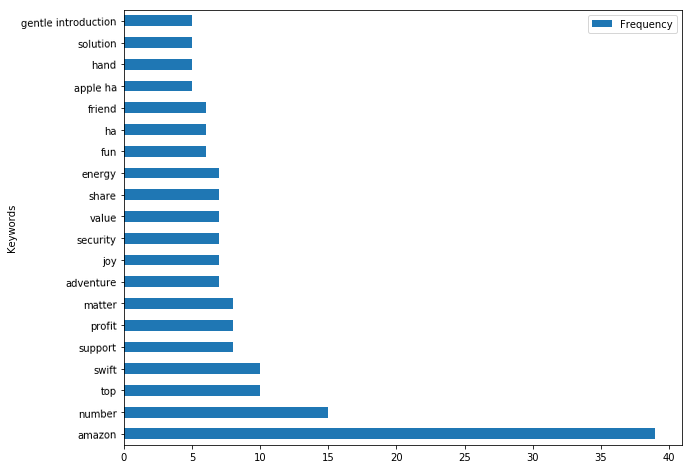

In [97]:
#converting RDD to spark dataframe
df_fDist = freq_pos_link_titles.toDF()

df_fDist.createOrReplaceTempView("myTable") 

#renaming columns 
df2 = spark.sql("SELECT _1 AS Keywords, _2 as Frequency from myTable limit 20") 

 #converting spark dataframes to pandas dataframes
pandD = df2.toPandas()
pandD.plot.barh(x='Keywords', y='Frequency', rot=1, figsize=(10,8))